In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os 
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
%cd /content/gdrive/My Drive/Kaggle
!kaggle datasets download -d eswarchandt/amazon-music-reviews

/content/gdrive/My Drive/Kaggle
100% 4.69M/4.69M [00:00<00:00, 32.3MB/s]



In [4]:
!unzip \*.zip&& rm *.zip

Archive:  amazon-music-reviews.zip
  inflating: Musical_Instruments_5.json  
  inflating: Musical_instruments_reviews.csv  


In [23]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

import nltk 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords, wordnet 
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from bs4 import BeautifulSoup
import re, string, unicodedata
from nltk.tokenize.toktok import ToktokTokenizer 
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
import nltk
import keras 
from keras.layers import Dense, LSTM
from keras.models import Sequential

In [7]:
df = pd.read_csv('./Musical_instruments_reviews.csv')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [8]:
pd.DataFrame(df.isna().sum())

,0
reviewerID,0
asin,0
reviewerName,27
helpful,0
reviewText,7
overall,0
summary,0
unixReviewTime,0
reviewTime,0


In [9]:
df.reviewText.fillna("", inplace=True)

In [10]:
del df['reviewerID']
del df['asin']
del df['reviewerName']
del df['helpful']
del df['unixReviewTime']
del df['reviewTime']


In [11]:
df.head()

,reviewText,overall,summary
0,"Not much to write about here, but it does exac...",5.0,good
1,The product does exactly as it should and is q...,5.0,Jake
2,The primary job of this device is to block the...,5.0,It Does The Job Well
3,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY
4,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.


In [12]:
df['text'] = df['reviewText'] + " " + df['summary']
del df['reviewText']
del df['summary']

In [13]:
df.head()

,overall,text
0,5.0,"Not much to write about here, but it does exac..."
1,5.0,The product does exactly as it should and is q...
2,5.0,The primary job of this device is to block the...
3,5.0,Nice windscreen protects my MXL mic and preven...
4,5.0,This pop filter is great. It looks and perform...


In [14]:
df.overall.value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

In [15]:
def sentiment_rating(rating):
    if (int(rating) == 1 or int(rating) == 2 or int(rating) == 3):
        return 0 
    else : 
        return 1

df.overall = df.overall.apply(sentiment_rating)

In [18]:
df.overall.value_counts()

1    9022
0    1239
Name: overall, dtype: int64

In [20]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
print(stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'some', 'i', 'him', 'now', "mustn't", "shouldn't", 'that', '?', "won't", 'between', 'further', 'than', 'for', "you'd", 'your', 'had', 'were', "isn't", "you'll", 'each', '+', 'too', '"', 'themselves', 'below', 'being', 'with', 'after', 'in', "weren't", '[', 'mightn', 'before', 'he', 'only', 'and', 'should', 'such', 'other', '(', 'hers', "haven't", 'll', 'while', 'theirs', "it's", 'this', '&', ']', 'more', 'again', 'ma', 'them', 'herself', 'into', 've', '*', 'so', '\\', 'isn', 'don', 'they', 'out', 'd', 'weren', "aren't", 'who', 'his', '%', 'we', 'hasn', 'why', 'nor', 'how', 'needn', 'are', 'but', ')', "hadn't", '^', "doesn't", ';', 'didn', "should've", 'ain', '>', 'do', 'until', 'most', '-', "hasn't", 'shouldn', 'when', 'whom', 'ours', 't', ':', 'am', 'these', 'above', "don't", "wasn't", 'there', 'which', 'then', '<', 'y', 'own', 'against', 'over', 'our', 'not', "needn't", 'ha

In [26]:
nltk.download('wordnet')
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ

    elif tag.startswith('V'):
        return wordnet.VERB

    elif tag.startswith('N'):
        return wordnet.NOUN

    elif tag.startswith('R'):
        return wordnet.ADV
    
    else: 
        return wordnet.NOUN

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [28]:
get_simple_pos('Rhj')

'r'

In [31]:
lemmatizer = WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop: 
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(), get_simple_pos(pos[0][1]))

            final_text.append(word.lower())
    
    return " ".join(final_text)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [32]:
df.text = df.text.apply(lemmatize_words)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df.text,
                                                    df.overall,
                                                    test_size=0.2,
                                                    random_state=0)


In [34]:
good = X_train[y_train[y_train==1].index]
bad = X_train[y_train[y_train==0].index]

X_train.shape, good.shape, bad.shape

((8208,), (7197,), (1011,))

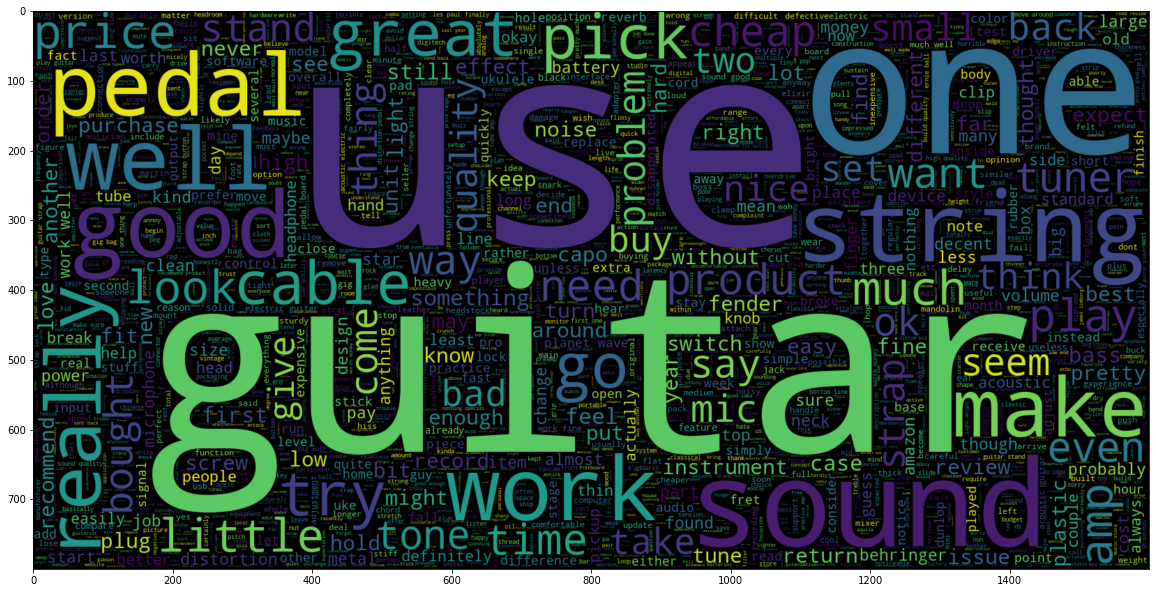

In [35]:
plt.figure(figsize=(20, 20))
wc = WordCloud(min_font_size=3, max_words=3000, width=1600, height=800).generate(" ".join(bad))
plt.imshow(wc, interpolation='bilinear')

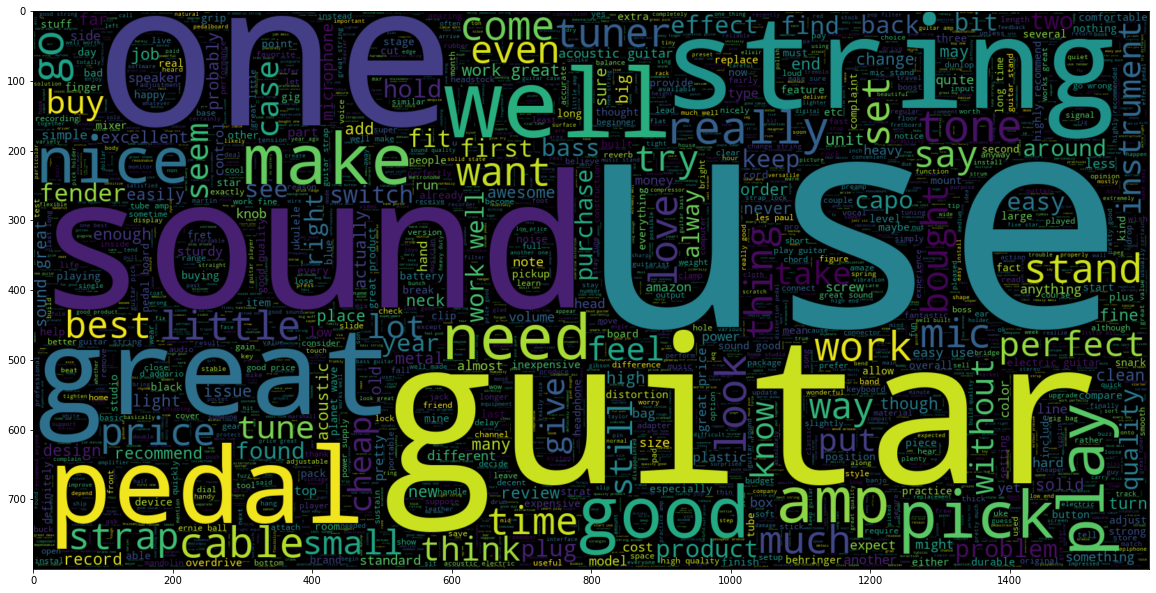

In [36]:
plt.figure(figsize=(20, 20))
wc = WordCloud(min_font_size=3, max_words=3000, width=1600, height=800).generate(" ".join(good))
plt.imshow(wc, interpolation='bilinear')

In [37]:
df.text

0        much write here, exactly suppose to. filter po...
1        product exactly quite affordable.i realize dou...
2        primary job device block breath would otherwis...
3        nice windscreen protects mxl mic prevents pops...
4        pop filter great. look performs like studio fi...
                               ...                        
10256               great, expected. thank all. five stars
10257    i've think try nanoweb string while, bit put h...
10258    try coat string past include elixirs) never fo...
10259    well, made elixir developed taylor guitars ......
10260    string really quite good, call perfect. unwoun...
Name: text, Length: 10261, dtype: object

In [38]:
cv = CountVectorizer(min_df=0, max_df=1, binary=False, ngram_range=(1, 3))

cv_train_reviews = cv.fit_transform(X_train)
cv_test_reviews = cv.transform(X_test)


print('BOW_CV_TRAIN : ', cv_train_reviews.shape)
print('BOW_CV_TRAIN :', cv_test_reviews.shape)

BOW_CV_TRAIN :  (8208, 573616)
BOW_CV_TRAIN : (2053, 573616)


In [39]:
tv  = TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range=(1, 3))

# transformed train reviews 
tv_train_reviews = tv.fit_transform(X_train)

# transformed test reviews 
tv_test_reviews = tv.transform(X_test)

print('TFIDF _train', tv_train_reviews.shape)
print('TFIDF test', tv_test_reviews.shape)

TFIDF _train (8208, 573616)
TFIDF test (2053, 573616)


In [42]:
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=0)
# fitting the model for BAG OF WORDS 
lr_bow = lr.fit(cv_train_reviews, y_train)
print(lr_bow)

lr_tfidf = lr.fit(tv_train_reviews, y_train)
print(lr_tfidf)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [43]:
# Predicting the model for BAG OF WORDS 
lr_bow_predict = lr_bow.predict(cv_test_reviews)
lr_tfidf_predict = lr_tfidf.predict(tv_test_reviews)



In [44]:
print("LR BOW SCORE", accuracy_score(y_test, lr_bow_predict))
print("LR TFIDF SCORE", accuracy_score(y_test, lr_tfidf_predict))

LR BOW SCORE 0.8904042864101315
LR TFIDF SCORE 0.8889430102289333
